In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import open3d as o3d
from datetime import datetime

from utils import *
from bpy_utils import ManusData, get_fbx_creation_time

import sys
manopth_dir = 'C:/Users/lucas/Desktop/UPC/MIT/manopth/'
sys.path.insert(1, manopth_dir)

from manus.utils import Pressure

In [3]:
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210722/round_2_fixed_wooden_cube/"
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210722/round_3_fixed_bottle_pose_1/"
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/intrinsics_extrinsics/data/20210727_woIMU/r3/"

for name in os.listdir(recording_dir):
    name_pth = os.path.join(recording_dir, name)
    
    if os.path.isdir(name_pth):
        print("recording:", name)
        cameras_dir = name_pth
        
    elif ".hdf5" in name:
        print("pressure_file:", name)
        perssure_pth = name_pth
        
    elif ".fbx" in name:
        print("manus_file:", name)
        manus_pth = name_pth
        
#cameras_dir = os.path.join(recording_dir, "20210722_152500")
#perssure_pth = os.path.join(recording_dir, ".hdf5")
#manus_pth = os.path.join(recording_dir, ".fbx")

pressure_file: 07272021_3.hdf5
recording: 20210727_173327
manus_file: recording_2021-07-27_16-34-36.fbx


# Load data

In [4]:
%%capture

cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(cameras_dir, use_txt=False)
extrinsics = Extrinsics(cameras_dir)
rgbds = RGBD(cameras_dir)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)
apriltags = AprilTags(cameras_dir, intrinsics, extrinsics, cameras=cameras)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)

pressure = Pressure(perssure_pth, lim_low=3, lim_high=50)

manus = ManusData(manus_pth, manopth_dir)

# Synchronize

#### Get timestamps

In [9]:
# Camera timestamps
ts_camera = get_camera_timestamps(cameras_dir)

# Pressure timestamps
ts_pressure = pressure.ts_touch

# MANUS timestamp
pyfbx_i42_pth = "C:/Users/lucas/Desktop/UPC/MIT/pyfbx_i42-master/"
ts_end = get_fbx_creation_time(manus_pth, pyfbx_i42_pth)
ts_start = ts_end - len(manus) / 20
ts_manus = manus.get_ts(fps=20, ts_start=ts_start)

#### Find pressure camera offset


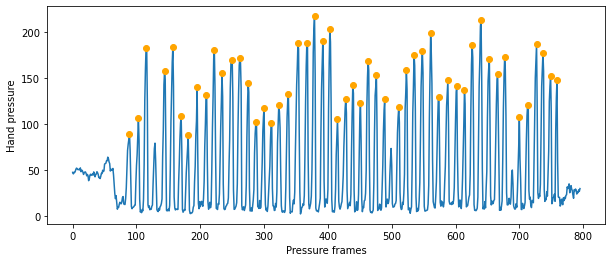

In [10]:
pressure.plot_peaks(height=80)

In [11]:
# Index of first pressure peak 
idx_first_p = pressure.get_peaks(height=80)[0]
# Timestamp of first pressure peak
ts_first_p = pressure.ts_touch[idx_first_p]

# Frame of first pressure in camera
frame_first_c = 108
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
pc_offset = ts_first_p - ts_first_c

#### Synchronize pressure + camera + manus

In [15]:
synchronize = Synchronizer(ts_p=ts_pressure, ts_c=ts_camera, ts_m=ts_manus, pc_offset=pc_offset, mc_offset=0)

# Estimate object position

In [ ]:
%%capture

pcd = stitched_pcd["000000"]

obj_name = "005_tomato_soup_can"
obj_name = "003_cracker_box"
obj_name = "006_mustard_bottle"
obj_name = "036_wood_block"

obj_pth = f"C:/Users/lucas/Desktop/UPC/MIT/tactile2object/estimate_object_pose/ycb_converted/{obj_name}.ply"

# Useful when running the cell multiple times
try:
    obj_mesh_t # obj_mesh_t exist in the current namespace
except NameError:
    transformation, obj_mesh_t = find_object_transformation(pcd, obj_pth)

In [ ]:
#o3d.visualization.draw_geometries([pcd, obj_mesh_t])

# Plot mesh_hand + object + AprilTag

In [ ]:
frame_c = 652
frame_m = synchronize.camera_to_manus(frame_c)
frame_c = str(frame_c).zfill(6)

# pcd = stitched_pcd[frame_c]
corners_w = apriltags.corners_w(idx=frame_c)

rectangle = get_rectangle_from_corners(corners_w)
mesh_hand = manus.from_corners(frame_m, corners_w)

o3d.visualization.draw_geometries([mesh_hand, obj_mesh_t, rectangle, stitched_pcd[frame_c]])

# Save MANO projected to the camera frame

In [14]:
width = 640
height = 480

cx = width / 2 - 0.5
cy = height / 2 - 0.5

for camera in cameras:
    out_dir = os.path.join(apriltags.cameras_dir, "imgs", "camera_manus", camera)

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    
    camera_viewpoint = o3d.camera.PinholeCameraParameters()
    camera_viewpoint.extrinsic = extrinsics.from_camera(camera=camera)
    fx, fy, _, _ = intrinsics.params_from_camera(camera=camera)
    camera_viewpoint.intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

    viewpoint_file = os.path.join(cameras_dir, f"{camera}_viewpoint.json")
    o3d.io.write_pinhole_camera_parameters(viewpoint_file, camera_viewpoint)
    
    for frame_c in range(0, 1759):
        frame_c = str(frame_c).zfill(6)
        out_pth = os.path.join(out_dir, f"img_{frame_c}.png")
        
        corners_w = apriltags.corners_w(idx=frame_c)
        
        if corners_w is not None:
            rectangle = get_rectangle_from_corners(corners_w)
            frame_m = synchronize.camera_to_manus(frame_c)
            mesh_hand = manus.from_corners(frame_m, corners_w)
        
            save_draw_geometries([mesh_hand,rectangle], out_pth, viewpoint_file, width, height)

### Remove background

In [ ]:
from PIL import Image

In [ ]:
all_transparent_img = np.zeros((480,640,4),dtype=np.uint8)

for camera in cameras:
    out_dir = os.path.join(apriltags.cameras_dir, "imgs", "camera_manus", camera)
    
    for frame_c in range(0, 1759):
        frame_c = str(frame_c).zfill(6)
        out_pth = os.path.join(out_dir, f"img_{frame_c}.png")
        
        # Remove background
        if os.path.exists(out_pth):
            image = Image.open(in_pth)
            # convert image to numpy array
            transparent_img = np.ones((480,640,4),dtype=np.uint8) * 255
            transparent_img[:,:,:3] = np.asarray(image)
            white_idx = np.argwhere(np.sum(transparent_img, axis=-1) > 1015)
            transparent_img[white_idx[:,0],white_idx[:,1],-1] = 0
            
        else:
            transparent_img = all_transparent_img
            
        img = Image.fromarray(transparent_img, 'RGBA')  
        img.save(out_pth)
        
        break
        